# 1. Vehicle Routing Problem (VRP) demo with OSMnx and OR-Tools

This repository demonstrates the usage of [OR-Tools](https://developers.google.com/optimization) and [OSMnx](https://github.com/gboeing/osmnx).

## What is VRP?
Vehicle Routing Problem (VRP) is a combinatorial optimization problem that involves finding the optimal set of routes for a fleet of vehicles to visit a set of locations, subject to various constraints. It is a well-known problem in the field of operations research and has many practical applications such as logistics, transportation, and supply chain management.

## What is OR-Tools?
OR-Tools is an open-source software suite for optimization developed by Google. It includes a wide range of solvers and tools for solving various types of optimization problems, including VRP.

## What is OSMnx?
OSMnx is a Python library for working with [OpenStreetMap](https://www.openstreetmap.org/) (OSM) data. It allows you to download OSM data, visualize it, and perform various spatial analyses on it. In this notebook, we will use OSMnx to download street network data for a specific location.

## What is the goal of this notebook?
The goal of this notebook is to demonstrate how to solve a VRP using OR-Tools and OSMnx. Specifically, we will use OSMnx to download street network data for a specific location, and then use OR-Tools to find the optimal set of routes for a fleet of vehicles to visit a set of bus stops in that location, subject to various constraints such as vehicle capacity and maximum distance traveled. Finally, we will visualize the results on a map using folium. This notebook is intended for anyone who is interested in learning about VRP, OR-Tools, and OSMnx, regardless of their level of expertise in these areas.

In [1]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [2]:
# Specify the center location (latitude, longtitude)
CENTER_LOCATION = (35.6889646, 139.7816839)

# Specify distance in meters
DIST = 500

# Specify the number of vehicles
NUM_VEHICLES = 4

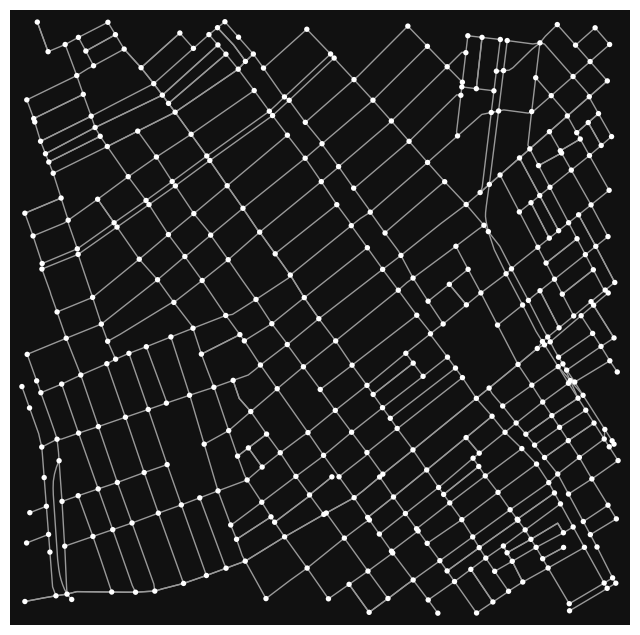

In [3]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

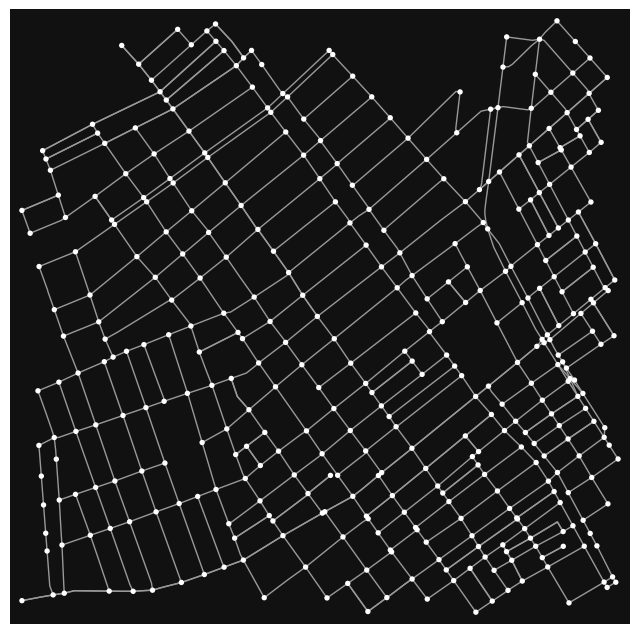

In [4]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

In [5]:
# Use the nearest node to the center location as the depot
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])
depot

1054155212

In [6]:
# Find bus stops
bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
bus_stop_nodes = list(map(itemgetter(1), bus_stops.index.values))
bus_stop_nodes[:5]

[1892744308, 1937182801, 2264347181, 2365963948, 2365964040]

In [7]:
# Combine depot and bus_stops
nodes = [depot] + bus_stop_nodes
nodes[:5]

[1054155212, 1892744308, 1937182801, 2264347181, 2365963948]

In [8]:
# Add bus stops to the highway graph
for index, bus_stop in bus_stops.iterrows():
    nearest_node = ox.distance.nearest_nodes(G, bus_stop.geometry.x, bus_stop.geometry.y)
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (bus_stop.geometry.y, bus_stop.geometry.x))

    # Add bus stop node
    G.add_node(index[1], x=bus_stop.geometry.x, y=bus_stop.geometry.y)
    
    # Add bidirectional edge
    G.add_edge(index[1], nearest_node, weight=distance.m)
    G.add_edge(nearest_node, index[1], weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head()

osmid oneway  ref   name      highway reversed   
u         v          key                                                       
257371953 1054597774 0     38790699   True  316   昭和通り      primary    False  \
260102619 1105291073 0    368086828   True  NaN  清洲橋通り     tertiary    False   
          1105290753 0     95282565   True  NaN    NaN  residential    False   
260102622 3719485523 0    368086828   True  NaN  清洲橋通り     tertiary    False   
          3719485538 0    368086832   True  NaN  清洲橋通り     tertiary    False   

                          length   
u         v          key           
257371953 1054597774 0    81.798  \
260102619 1105291073 0    13.337   
          1105290753 0    69.016   
260102622 3719485523 0    73.149   
          3719485538 0    76.199   

                                                                   geometry   
u         v          key                                                      
257371953 1054597774 0    LINESTRING (139.77653 35.68789, 139.77668 35.6...  \
260102619 1105291073 0    LINESTRING (139.78605 35.68842, 139.78613 35.6...   
          1105290753 0    LINESTRING (139.78605 35.68842, 139.78614 35.6...   
260102622 3719485523 0    LINESTRING (139.78476 35.69030, 139.78497 35.6...   
          3719485538 0    LINESTRING (139.78476 35.69030, 139.78486 35.6...   

                         lanes maxspeed access  weight  
u         v          key                                
257371953 1054597774 0     NaN      NaN    NaN     NaN  
260102619 1105291073 0     NaN      NaN    NaN     NaN  
          1105290753 0     NaN      NaN    NaN     NaN  
260102622 3719485523 0     NaN      NaN    NaN     NaN  
          3719485538 0     NaN      NaN    NaN     NaN

<Figure size 640x480 with 0 Axes>

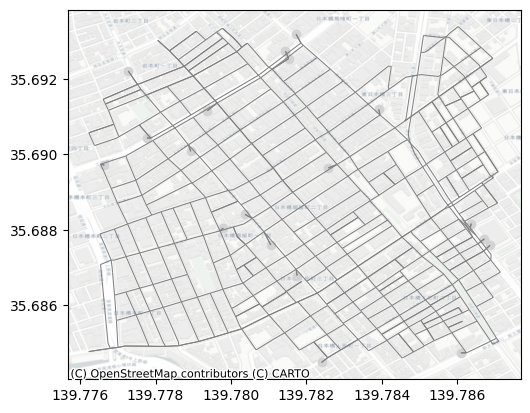

In [9]:
# Create a new figure object
ax = plt.figure()

# Plot the highway graph
ax = edges.plot(linewidth=0.75, color='gray')

# Plot the bus stops
ax = bus_stops.plot(ax=ax, facecolor='lightgray')

# Turn off offsetting of tick labels
ax.ticklabel_format(useOffset=False)

# Add a basemap to the figure object
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.CartoDB.Positron)

In [10]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(nodes), NUM_VEHICLES, nodes.index(depot))

# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [11]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [12]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [13]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [14]:
# Print the solution
total_distance = 0
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 3 -> 18 -> 8 -> 14 -> 11 -> 0
Distance of route: 46m

Route for vehicle 1:
0 -> 7 -> 9 -> 5 -> 12 -> 13 -> 6 -> 0
Distance of route: 45m

Route for vehicle 2:
0 -> 4 -> 2 -> 0
Distance of route: 51m

Route for vehicle 3:
0 -> 15 -> 16 -> 10 -> 17 -> 1 -> 19 -> 0
Distance of route: 48m

Total distance of all routes: 190m


In [15]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops.iterrows():
    stop_coords = (bus_stop.geometry.y, bus_stop.geometry.x)
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % NUM_VEHICLES]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m